# <u>Sea Level Rise Inundation Tool </u>

#### Meg Manning -- *Duke University, Fall 2024*

► **Description:** this script can be used to identify an area in the coastal plain of North Carolina and assess it's risk to sea level rise. This tool creates three layers of inundation under 1ft, 2ft, and 3ft of SLR. Methods for forecasting sea level rise inundation were taken from the National Oceanic and Atmospheric detailed methology for sea level rise inundation (NOAA, 2017). A threat index tool is in the process of being built to consider different environmental factors, coupled with SLR, including storm surge of category 1-5 hurricanes, flood prone areas, soil erodibility, drainage, and areas of low slope. This tool will use the National Fish and Wildlife Service's Coastal Resilience and Siting Tool (CREST) methodology for calculations (Dobson et al., 2019).

### 1. Digital Elevation Model from LiDAR 

*Download LiDAR point data and process into a 1m DEM.*

#### LiDAR data must be downloaded following these steps *prior* to running the rest of this script. 

<u> Step 1: Download LiDAR Data </u> 

Click the link below to open the Digital Coast Topobathy LiDAR Web Interface: https://coast.noaa.gov/dataviewer/#/lidar/search/ 

<u>Step 1.1:</u> Zoom in to a scale of at least 1000ft, if not 500ft, and draw a box around the area of interest

<u>Step 1.2:</u> In the panel on the right, select the most recent *point* data that corresponds to the area of interest

<u>Step 1.3:</u> Click "Add to Cart" 

<u>Step 1.4:</u> In your cart, set the following parameters for your point data:
* Projection = UTM
* Zone = Zone 18 Range 078W-072W
* Horizontal Datum = NAD83
* Horizontal Units = Meters
* Vertical Datum = NADV88
* Vertical Units = Meters
* Output Product = Point
* Output Format = Points - LAS
* Data Classes = Ground 

<u>Step 1.5:</u> Click next, add email, review and submit

*It may take a few minutes for the data to process but you will recieve an email with the link to download the data. Once it downloads, extract the data to your machine and note the file path.*

<u> Step 2: Process into a 1m DEM</u> 

In [7]:
# Load Necessary Packages
import arcpy
import os
from arcpy.ia import *
from arcpy.sa import *

# Set the workspace 
#output_directory = arcpy.GetParameterAsText(0)
output_directory = arcpy.env.workspace = "z:\MP\Scratch" # THIS NEEDS TO BE USER INPUT
arcpy.env.overwriteOutput = True

In [8]:
# Define LAS data and LAS dataset paths 
# las_folder = arcpy.GetParameterAsText(1) 
# las_dataset = arcpy.GetParameterAsText(2) 
las_folder = "z://MP//DATA//Lidar//nc2019_dunex_Job1104540"
las_dataset = "z://MP//DATA//Lidar//nc2019_dunex_Job1104540//nc2019_dunex_Job1104540.lasd"

# Create a LAS Dataset using Create LAS Dataset Tool 
arcpy.management.CreateLasDataset(las_folder, las_dataset)
arcpy.AddMessage(f"LAS Dataset successfully created.")

In [9]:
# Define output raster (DEM) path 
ground_DEM_output = output_directory + "DEM_1m.tif"

In [10]:
# Create 1m DEM using LAS Dataset to Raster tool 
DEM_1m = arcpy.conversion.LasDatasetToRaster(las_dataset, ground_DEM_output, 
                                    'ELEVATION', 
                                    'BINNING AVERAGE LINEAR', 
                                    'FLOAT', 
                                    'CELLSIZE', 1, 1)

### 2. Tidal Variability Surface Using Vertical Datum Tool

*Use DEM created above to create a tidal surface raster that shows the tidal fluctuations at the area of interest. Once this is created then sea level rise inundation can be calculated.*

https://vdatum.noaa.gov/docs/services.html#step120

In [1]:
import arcpy
from arcgis.gis import GIS
from arcgis.raster import Raster

In [3]:
tidal_url = "https://chs.coast.noaa.gov/htdata/Inundation/SLR/BulkDownload/Tidal_Surfaces/NC_MHHW_GCS_50m_NAVDm.tif"
tidal_raster = Raster(tidal_url)

In [4]:
# Load in tidal surface for Springer's Point 
SP_tidal_path = "z:\MP\DATA\Tidal_Surface\SP_tidalsurface.tif"
SP_tidal_raster = Raster(SP_tidal_path)

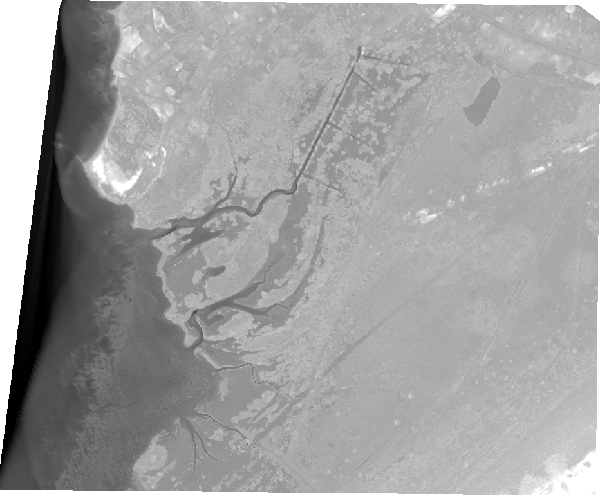

In [15]:
ground_DEM_SP = Raster(DEM_1m)
ground_DEM_SP

In [ ]:
desc = arcpy.Describe(SP_tidal_path)
extent = desc.extent
xmin = extent.XMin
xmax = extent.XMax
ymin = extent.YMin
ymax = extent.YMax

print(f"{xmin} {ymin} {xmax} {ymax}")


409797.65 3884197.39 410665.65 3885305.39


https://github.com/noaa-ocs-hydrography/vyperdatum/blob/main/vyperdatum/points.py
https://coast.noaa.gov/slrdata/Tidal_Surfaces/URLlist_Tidal_Surfaces.txt
https://vdatum.noaa.gov/docs/gtx_info.html

In [39]:
# Set output raster 
clip_output = "../Scratch/clipped_DEM1.tif"
arcpy.env.overwriteOutput = True

# Clip the DEM to the tidal raster 
#arcpy.management.Clip(ground_DEM_SP, "409797.65 3884197.39 410665.65 3885305.39", 
                     # clip_output,
                     # SP_tidal_raster)

In [ ]:
# Create Points from DEM to input into VDatum tool to get conversion from MHHW into NAVD88

# Raster to Point - set local variables 
in_DEM = DEM_1m
out_point_features = 'DEM_points.shp'
field = "VALUE"

# Run the tool
# arcpy.conversion.RasterToPoint(in_DEM, out_point_features, field)

#IS THERE AN EASIER WAY TO DO THIS?

### 3. Inundation Extent under 1-3ft SLR

*Use both the DEM in step 1 and the tidal variabliity surface in step 2 to model the desired amount of sea level rise at 1 meter resolution on top of the area of interest. For detailed methods see Detailed Method for Mapping Sea Level Rise Inundation (NOAA, 2017).*

<u> Iterate through sea level rise of 1ft (0.3048m), 2ft (0.6096m), and 3ft (0.9144m) for area of interest using tidal variability surface.</u>

In [ ]:
# Load necessary packages 
import arcpy
from arcpy.ia import *
from arcpy.sa import *
import os

# Allow outputs to be overwritten
arcpy.env.overwriteOutput = True

# Check out any necessary licenses.
arcpy.CheckOutExtension("3D")
arcpy.CheckOutExtension("spatial")
arcpy.CheckOutExtension("ImageAnalyst")

# Create function to iterate through SLR of 1-3ft
SLR_values = [0.3048, 0.6096, 0.9144]

# Convert to feet 
SLR_names = {0.3048: "1ft", 0.6096: "2ft", 0.9144: "3ft"}

# Load local tidal surface in 

# Create a function to process inundation for all SLR values 
def process_inundation(SLR_value, DEM_1m, output_directory) :
    # Add SLR amount to surface 
    surface_raster = Raster(DEM_1m) + SLR_value
    surface_raster_output = os.path.join(output_directory, f'surface_{SLR_value}m.tif')
    surface_raster.save(surface_raster_output)

    # Load ground DEM as Raster 
    input_con = Raster(DEM_1m)

    # Raster Calculator - create single value DEM to show inundation extent
    single = Con(input_con <= surface_raster, 1)
    single_output = os.path.join(output_directory, f'single_{SLR_value}m.tif')
    single.save(single_output)

    # Region Group - Evaluate connectivity of extent raster using region group
    clumped = arcpy.sa.RegionGroup(single, "EIGHT", "WITHIN", "NO_LINK", None)
    clumped_output = os.path.join(output_directory, f'clumped_{SLR_value}m.tif')
    clumped.save(clumped_output)

    # Extract by Attributes - Extract connected inundation surface to be used as a mask for the original depth grid
    lowlying = arcpy.sa.ExtractByAttributes(clumped, "Count < 1000000")
    lowlying_output = os.path.join(output_directory, f'lowlying_{SLR_value}m.tif')
    lowlying.save(lowlying_output)

    # Raster Calculator (2) - Subtract DEM values from water surface to derive initial inundatino depth grid
    depth =  Con(input_con <= surface_raster, surface_raster - input_con) 
    depth_output = os.path.join(output_directory, f'depth_{SLR_value}m.tif')
    depth.save(depth_output)
    
    # Extract by Attributes (2) - Derive low-lying areas 
    connect = arcpy.sa.ExtractByAttributes(clumped, "Count > 1000000")
    connect_output = os.path.join(output_directory, f'connect_{SLR_value}m.tif')
    connect.save(connect_output)

    # Extract by Mask - Create depth grid for connected areas
    SLR_in_feet = SLR_names[SLR_value]
    con_depth = arcpy.sa.ExtractByMask(depth, connect)
    con_depth_output = os.path.join(output_directory, f'SLR_Inundation_{SLR_in_feet}.tif')
    con_depth.save(con_depth_output)

    print(f"Processed SLR = {SLR_value}m, saved as {con_depth_output}")

# Iterate through each SLR value (1ft, 2ft, 3ft)
for SLR_value in SLR_values:
    process_inundation(SLR_value, DEM_1m, output_directory)


Processed SLR = 0.3048m, saved as z:\MP\Scratch\SLR_Inundation_1ft.tif
Processed SLR = 0.6096m, saved as z:\MP\Scratch\SLR_Inundation_2ft.tif
Processed SLR = 0.9144m, saved as z:\MP\Scratch\SLR_Inundation_3ft.tif


#### References 

#### Dobson, G., Johnson, I., Rhodes, K., Hutchins, M., & Chesnutt, M. (2019). Regional coastal resilience assessment: Methodology. National Fish and Wildlife Foundation. Retrieved November 21, 2024, from https://www.nfwf.org/sites/default/files/coastalresilience/Documents/regional-coastal-resilience-assessment.pdf

#### National Oceanic and Atmospheric Administration. (2017, January). Sea level rise inundation methods: Technical documentation. NOAA Office for Coastal Management. Retrieved November 21, 2024, from https://coast.noaa.gov/data/digitalcoast/pdf/slr-inundation-methods.
